# qPCR Data Analysis Notebook


- This notebook extracts data from Applied Biosystems qPCR results spreadsheets and proceeds to calculate 2^-dCT and 2^-ddCT.
- User input of folder path, target genes, housekeeping gene, and control sample (for 2^-ddCT).
- The script filters out outliers that are >1 away from the technical replicate median.
- Notebook should run in virtual environment with the packages and package versions stated in the .yaml file.

## 1. Import libraries and modules
- Do not install entire libraries every time your notebook - these will already be installed in the conda environment.
- Do import modules every time you open notebook - these are wiped between sessions.

In [1]:
# check what libraries are installed in conda environment
!conda list

# packages in environment at C:\Anaconda3\envs\l2dVE:
#
# Name                    Version                   Build  Channel
anyio                     4.8.0                    pypi_0    pypi
argon2-cffi               23.1.0                   pypi_0    pypi
argon2-cffi-bindings      21.2.0                   pypi_0    pypi
arrow                     1.3.0                    pypi_0    pypi
asttokens                 3.0.0                    pypi_0    pypi
async-lru                 2.0.4                    pypi_0    pypi
attrs                     24.3.0                   pypi_0    pypi
babel                     2.16.0                   pypi_0    pypi
beautifulsoup4            4.12.3                   pypi_0    pypi
bleach                    6.2.0                    pypi_0    pypi
bzip2                     1.0.8                h2466b09_7    conda-forge
ca-certificates           2024.12.14           h56e8100_0    conda-forge
certifi                   2024.12.14               pypi_0    pypi
cffi 

In [1]:
from matplotlib import pyplot as plt 
import pandas as pd
import numpy as np
import scipy as sp 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import glob
import xlrd
from pathlib import Path
import os

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'xlrd'

## 2. Import qPCR data
- Imports data from spreadsheet exported from Applied Biosystem machine.
- Only imports 'Sample Name', 'Target Name', and 'CT'.
- Concatenates all spreadsheets within path folder to form one combined pandas dataframe.
- Drops 'NaN' and 'Undetermined' CT values.
- Extracts timepoint and culture condition from sample name 
    - e.g. from '138 ALG D1 STATIC' extracts 'D1' and 'STATIC' and indents into new collumns for timepoint and culture conditions.

In [2]:
# We want to dispaly all rows of data frame rather than truncated version so we can confirm it contains all data
# To display all rows
pd.set_option('display.max_rows', None)

# To display all columns
pd.set_option('display.max_columns', None)

In [19]:
import glob
import pandas as pd

# State folder path containing qPCR spreadsheets
folder_path_str = r'C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\5. Mechanical Stimulation\Main study\Primary\qPCR\raw_data'

# Read all Excel files into a list of dataframes
all_files = glob.glob(folder_path_str + "/*.xls")
li = []
for filename in all_files:
    df = pd.read_excel(filename, sheet_name='Results', header=7)

    # Rename 'Target' column to 'Target Name' if it exists
    if 'Target' in df.columns:
        df.rename(columns={'Target': 'Target Name'}, inplace=True)

    # Add the dataframe to the list
    li.append(df)

# Concatenate all dataframes
df = pd.concat(li, axis=0, ignore_index=True)

# Check if 'Target Name' column is in the dataframe
if 'Target Name' in df.columns:
    # Select the desired columns
    df = df[['Sample Name', 'Target Name', 'Cт']]

    # Rename the CT column
    df.rename(columns={'Cт': 'CT'}, inplace=True)

    # Drop rows with NaN
    df = df.dropna()

    # Filter out rows where CT is 'Undetermined'
    df = df[df['CT'] != 'Undetermined']

    
    # Convert CT column to numeric values
    df['CT'] = pd.to_numeric(df['CT'])

    # Group the dataframe by 'Sample Name' and 'Target Name'
    grouped_df = df.groupby(['Sample Name', 'Target Name'])



In [20]:
# Detect outliers using 1.5 x IQR rule
# first calculate Q1 and Q3 of grouped data using quantile function from numpy package
# the quantile is worked out based on rank order of values e.g. 0.5 quantile = median
# pandas automatically applies any function, i.e. quantile(), to each group seperately within a grouped dataframe
# This behaviour is inherent to 'groupby()' functionality in panda

Q1 = grouped_df['CT'].quantile(0.25)
Q3 = grouped_df['CT'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bound for outlier detection using 1.5 X IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers from each group
# This code uses the apply() function which allows you to apply a function along an axis of a dataframe or series
# this can be useful for aggregating and transforming data
# the function applies is a lambda function, aka anonymous function, which are small, inline functions defined without a name
# lambda functions are useful when you need a simple function for a short period of time e.g. for one line of code
# In this code lambda function takes one argument 'x' representing the grouped dataframe its being iterated over
# x['Ct'] indexes the Ct collumn from the grouped dataframe
# this codes only keeps data which is between lower and upper bound, filtering out other data with a boolean mask
# x.name represents the name of each group i.e. a tuple containing 'Sample Name' and'Target Name'
# Using x.name allows you to calculate the lower and upper bounds specific to each group, ensuring that outliers are determined based on the quartiles and IQR of each individual group's 'CT' values.
filtered_groups = grouped_df.apply(lambda x: x[(x['CT'] >= lower_bound[x.name]) & (x['CT'] <= upper_bound[x.name])], include_groups=False)

# Iterate through each group in the DataFrame
# need to groupby() again as we have applied a function to the previously grouped object, thus resulting in
# a combined data frame (split-apply-combine)
for group_key, group in filtered_groups.groupby(['Sample Name', 'Target Name']):

    # Get the number of samples within the group
    num_value = len(group)

    # state threshold value
    threshold = 1

    # If only one CT value is present, remove it
    # .loc() allows us ot access a group of rows and collumns by the labels being looped
    if num_value == 1:
        #filtered_groups.loc[group_key] = None
        filtered_groups.loc[group_key] = filtered_groups.loc[group_key]
    elif num_value == 2:
        # If 2 CT values are present, check that the absolute difference between them is less than threshold apart
        diff = np.abs(group['CT'].values[0] - group['CT'].values[1])
        # if the differece is above threshold, remove both CT value
        if diff > threshold:
            filtered_groups.loc[group_key] = None
    else:
        # for 3 CT values, work out the median and remove CT value than are greater than threshold away from median
        median_ct = np.median(group['CT'].values)
        diff = np.abs(group['CT'].values - median_ct)
        # check if any of the calculates diffrences beween ct and median are above threshold and remove CT values that are above threshold
        if np.any(diff > threshold):
            group = group[diff <= threshold]
        # if all CT values are more than threshold apart from median, remove them all
        elif np.all(diff > threshold):
            filtered_groups.loc[group_key] = None

        # update original dataframe with the modified group
        filtered_groups.loc[group_key] = group

# drop NaN values from filtered groups
filtered_groups = filtered_groups.dropna()

print('Filtered groups: \n', filtered_groups)
## This section of the for loop calculates 2^-dCT for each datafram

# first we calculate the mean CT values for each sample and target gene by grouping the data and using mean function
CT_mean = filtered_groups.groupby(['Sample Name', 'Target Name'])['CT'].mean()

# We can now reset the index of the dataframe so that the levels 'Sample Name' 'Target Nmae' now become collumn headers again. As our CT collumn now only contains one value, this makes it easier to index out data when calculating dCT and ddCT
CT_mean = CT_mean.reset_index()

print('Mean CT Values: \n', CT_mean)

Filtered groups: 
                                       CT
Sample Name   Target Name               
137 400 D1 S  ACAN        3    30.141579
                          4    30.433090
                          5    30.277205
              COL1A2      291  37.020802
                          292  35.993385
                          293  36.280266
137 400 D14 S ACAN        12   30.567932
                          13   30.410006
                          14   30.420124
              COL10A1     204  24.194069
                          205  24.227022
                          206  23.807276
              COL1A2      300  16.322466
                          301  16.238863
                          302  16.296181
              COL2A1      396  39.722652
                          398  39.185627
              SOX9        588  33.078102
                          589  33.099815
                          590  32.662533
              YWHAZ       684  21.869707
                          685  21.7772

In [21]:
# We want to create new collumns in the dataframe stating timepoint and culture conditions 
# Split the 'Sample Name' column into multiple columns
split_columns = CT_mean['Sample Name'].str.split(' ', expand=True)

# Assign the split parts to new columns with appropriate names
CT_mean['Biological Replicate'] = split_columns[0]
CT_mean['Reinforcement'] = split_columns[1]
CT_mean['Timepoint'] = split_columns[2]
CT_mean['Culture Conditions'] = split_columns[3]

# Drop the original 'Sample Name' column if no longer needed
CT_mean_split = CT_mean.drop(columns=['Sample Name'])

print(CT_mean_split)

    Target Name         CT Biological Replicate Reinforcement Timepoint  \
0          ACAN  30.283958                  137           400        D1   
1        COL1A2  36.431484                  137           400        D1   
2          ACAN  30.466021                  137           400       D14   
3       COL10A1  24.076122                  137           400       D14   
4        COL1A2  16.285837                  137           400       D14   
5        COL2A1  39.454140                  137           400       D14   
6          SOX9  32.946817                  137           400       D14   
7         YWHAZ  21.791002                  137           400       D14   
8          ACAN  25.015867                  137           400       D28   
9       COL10A1  20.271369                  137           400       D28   
10       COL1A2  15.422707                  137           400       D28   
11       COL2A1  23.532499                  137           400       D28   
12         SOX9  29.37377

## 3. Calculating dCT, ddCT, 2^-dCT and 2^-ddCT

In [31]:
# Assuming CT_mean_split is your DataFrame
# CT_mean_split has columns: 'Target Name', 'CT', 'Biological Replicate', 'Reinforcement', 'Timepoint', 'Culture Conditions'

# Input for housekeeping gene and control sample criteria
housekeeping_gene = input("Enter the housekeeping gene: ")  # Example: 'YWHAZ'
control_reinforcement = input("Enter the control reinforcement (e.g., 'Alg' for Alginate): ")  # Example: 'Alg'
control_timepoint = input("Enter the control timepoint (e.g., 'D1'): ")  # Example: 'D1'

In [32]:
# Step 1: Calculate dCT
# Pivot the DataFrame to have target names as columns
pivot_df = CT_mean_split.pivot_table(index=['Biological Replicate', 'Reinforcement', 'Timepoint', 'Culture Conditions'], 
                                     columns='Target Name', values='CT').reset_index()


# Calculate dCT for each sample (target gene - housekeeping gene)
# First we need to create a list containing target gene names
# We subtract the housekeeping gene's CT from each target gene's CT
target_genes = [col for col in pivot_df.columns if col not in ['Biological Replicate', 'Reinforcement', 'Timepoint', 'Culture Conditions', housekeeping_gene]]
for gene in target_genes:
    pivot_df[f'dCT {gene}'] = pivot_df[gene] - pivot_df[housekeeping_gene]

# print(target_genes)
# print(pivot_df)
# pivot_df['dCT'] = pivot_df.apply(lambda row: row.drop(['Biological Replicate', 'Reinforcement', 'Timepoint', 'Culture Conditions', housekeeping_gene]).values - row[housekeeping_gene], axis=1)


# Step 2: Identify control group based on user input
control_group = pivot_df[(pivot_df['Reinforcement'] == control_reinforcement) & 
                         (pivot_df['Timepoint'] == control_timepoint)]
                        

# Step 3: Calculate ddCT, 2^-dCT and 2^-ddCt and output results dataframe

# Initialize an empty DataFrame to store results
results_df = pivot_df.copy()

# Loop through each target gene
for gene in target_genes:
    # Calculate the mean dCT for the control group for the current gene
    control_dCT = control_group.groupby('Biological Replicate')[f'dCT {gene}'].mean().reset_index()
    control_dCT.columns = ['Biological Replicate', f'Control dCT {gene}']

    # Merge the control dCT values with the main DataFrame
    merged_df = pd.merge(results_df, control_dCT, on='Biological Replicate', how='left')

    # Calculate ddCT (ΔCT_sample - ΔCT_control)
    merged_df[f'ddCT {gene}'] = merged_df[f'dCT {gene}'] - merged_df[f'Control dCT {gene}']

    # Calculate 2^-dCT and 2^-ddCT
    merged_df[f'2^-dCT {gene}'] = 2 ** (-merged_df[f'dCT {gene}'])
    merged_df[f'2^-ddCT {gene}'] = 2 ** (-merged_df[f'ddCT {gene}'])
    
    # Update results_df to include the new columns
    results_df = merged_df





# Display the resulting DataFrame
print(results_df)

# Input results folder path
results_folder_path= r'C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\5. Mechanical Stimulation\Main study\Primary\qPCR\results'

# Input results file name
file_name = 'results.csv'
full_file_path = results_folder_path + '/' + file_name

# Save the DataFrame to the specified path
results_df.to_csv(full_file_path, index=False)



   Biological Replicate Reinforcement Timepoint Culture Conditions       ACAN  \
1                   137           400       D14                  S  30.466021   
2                   137           400       D28                  D  25.015867   
3                   137           400       D28                  S  24.312994   
4                   137           800        D1                  S  24.444950   
5                   137           800       D14                  S  29.709069   
6                   137           800       D28                  D  23.661077   
7                   137           800       D28                  S  23.433517   
8                   137           Alg        D1                  S  25.060378   
9                   137           Alg       D14                  S  27.397855   
10                  137           Alg       D28                  S  24.204891   
11                  164           400        D1                  S  21.913298   
12                  164     

## 4. Plot Results
- Using matplotlib and seaborne


C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\3404792757.py:11: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y='2^-dCT COL1A2', hue='Reinforcement',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\3404792757.py:22: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y='2^-ddCT COL1A2', hue='Reinforcement',


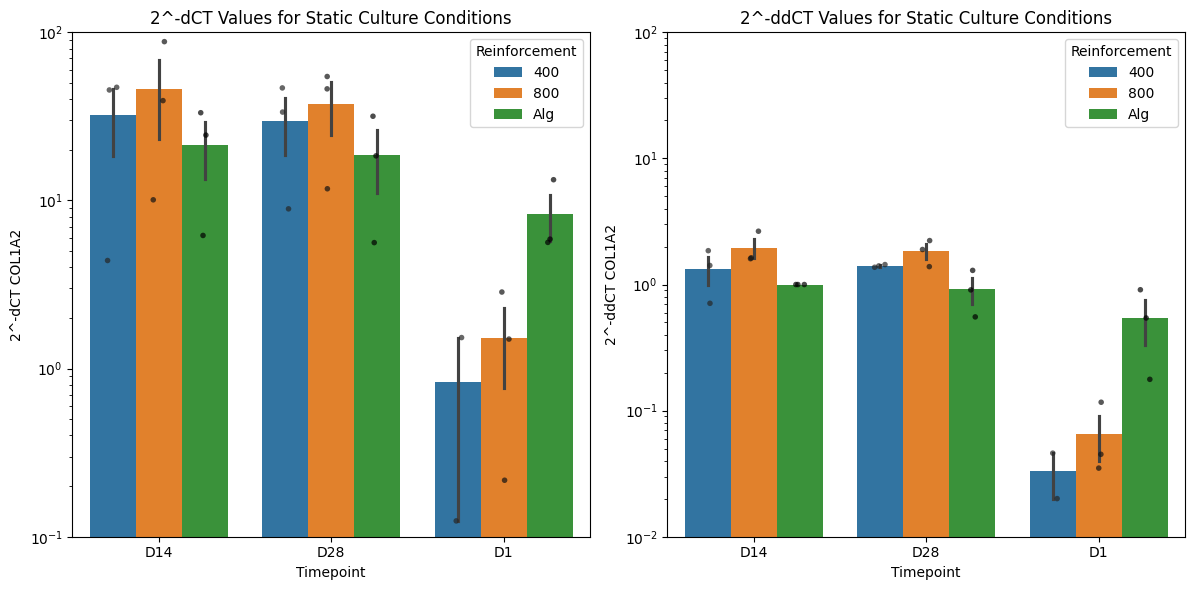

ANOVA for Static Culture Conditions:
                                 sum_sq    df          F    PR(>F)
C(Reinforcement)               1.061363   2.0   3.943051  0.039191
C(Timepoint)                   7.686422   2.0  28.555703  0.000004
C(Reinforcement):C(Timepoint)  2.089257   4.0   3.880883  0.020372
Residual                       2.287970  17.0        NaN       NaN

Tukey's HSD Test for Static Culture Conditions:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
 400 at D1 400 at D14   1.2942 0.0261  0.1123   2.476   True
 400 at D1 400 at D28    1.372 0.0165  0.1902  2.5539   True
 400 at D1  800 at D1   0.0325    1.0 -1.1493  1.2144  False
 400 at D1 800 at D14   1.9269 0.0006  0.7451  3.1088   True
 400 at D1 800 at D28   1.8048 0.0012  0.6229  2.9866   True
 400 at D1  Alg at D1     0.51 0.8304 -0.6718  1.6919  False
 400 at D1 Alg at D14    0.967

In [33]:
# First lets plot all rienforcement and timepoints under static condtions

# Step 1: Filter the data for static culture conditions
df_static = results_df[results_df['Culture Conditions'] == 'S']

# Step 2: Plot the bar chart for 2^-dCT values
# Create bar plots
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.barplot(data=df_static, x='Timepoint', y='2^-dCT COL1A2', hue='Reinforcement', errorbar="se")
sns.stripplot(data=df_static, x='Timepoint', y='2^-dCT COL1A2', hue='Reinforcement', 
              dodge=True, color='black', size=4, alpha=0.7, legend=False)
plt.yscale('log')  # Set y-axis to log scale
plt.ylim(1e-1, 1e2)  # Set y-axis limits to a wider range
plt.title('2^-dCT Values for Static Culture Conditions')
plt.ylabel('2^-dCT COL1A2')
plt.legend(title='Reinforcement')

# Step 3: Plot the bar chart for 2^-ddCT values
plt.subplot(1, 3, 2)
sns.barplot(data=df_static, x='Timepoint', y='2^-ddCT COL1A2', hue='Reinforcement', errorbar="se")
sns.stripplot(data=df_static, x='Timepoint', y='2^-ddCT COL1A2', hue='Reinforcement', 
              dodge=True, color='black', size=4, alpha=0.7, legend=False)
plt.yscale('log')  # Set y-axis to log scale 
plt.ylim(1e-2, 1e2)  # Set y-axis limits to a wider range
plt.title('2^-ddCT Values for Static Culture Conditions')
plt.ylabel('2^-ddCT COL1A2')
plt.legend(title='Reinforcement')


plt.tight_layout()
plt.show()

# Perform two-way ANOVA analysis 

model_static = ols('values ~ C(Reinforcement) * C(Timepoint)', 
                   data={'values': df_static['2^-ddCT COL1A2'], 
                         'Reinforcement': df_static['Reinforcement'], 
                         'Timepoint': df_static['Timepoint']}).fit()
anova_static = sm.stats.anova_lm(model_static, typ=2)

print("ANOVA for Static Culture Conditions:")
print(anova_static)

mc_static = pairwise_tukeyhsd(endog=df_static['2^-ddCT COL1A2'], 
                              groups=df_static['Reinforcement'] + ' at ' + df_static['Timepoint'],
                              alpha=0.05)
print("\nTukey's HSD Test for Static Culture Conditions:")
print(mc_static.summary())

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1293383871.py:13: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y='2^-dCT COL1A2', hue='Culture Conditions',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1293383871.py:24: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y='2^-ddCT COL1A2', hue='Culture Conditions',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1293383871.py:27: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1e2)  # Set y-axis limits to a wider range


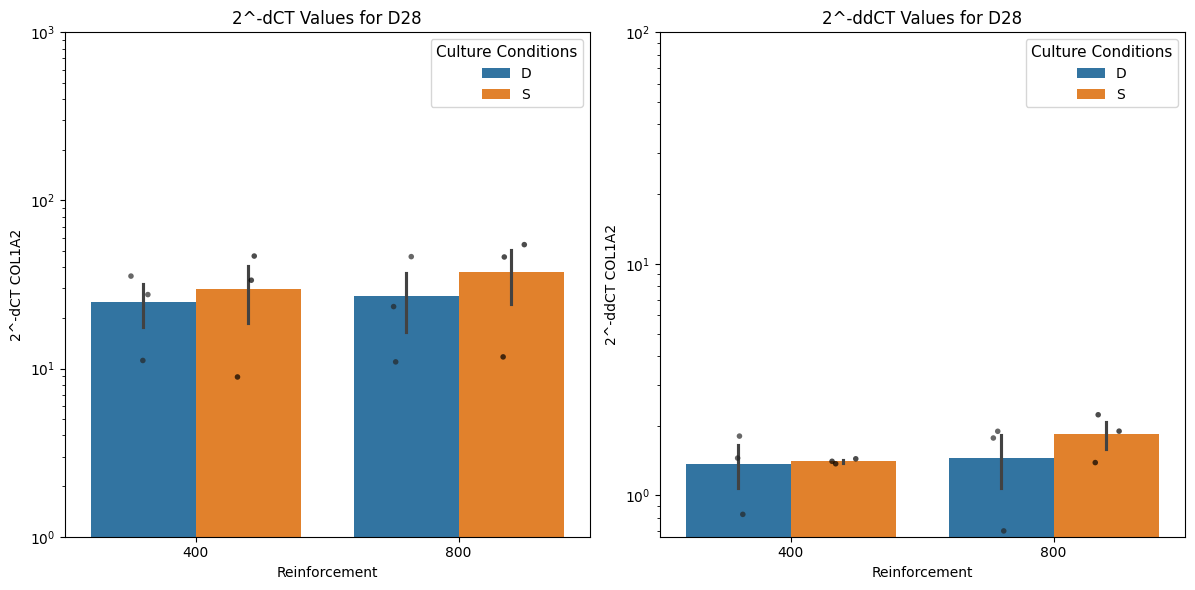

ANOVA for Last Timepoint (D28):
                                          sum_sq   df         F    PR(>F)
C(Reinforcement)                        0.208319  1.0  0.975321  0.352281
C(Culture_Conditions)                   0.136291  1.0  0.638094  0.447466
C(Reinforcement):C(Culture_Conditions)  0.085924  1.0  0.402286  0.543617
Residual                                1.708721  8.0       NaN       NaN

Tukey's HSD Test for Last Timepoint (D28):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
400 in D 400 in S   0.0439 0.9994 -1.1645 1.2523  False
400 in D 800 in D   0.0943 0.9941 -1.1141 1.3027  False
400 in D 800 in S   0.4767 0.6083 -0.7318 1.6851  False
400 in S 800 in D   0.0504 0.9991  -1.158 1.2588  False
400 in S 800 in S   0.4328 0.6734 -0.7757 1.6412  False
800 in D 800 in S   0.3824 0.7467  -0.826 1.5908  False
--------------------------------------------------

In [36]:
# Second lets just plot the last timepoint, comparing static and dynamic culture conditions

# Step 1: Filter the data for static culture conditions
df_end_timepoint = results_df[(results_df['Timepoint'] == 'D28') & (results_df['Reinforcement'].isin(['400', '800']))]



# Step 2: Plot the bar chart for 2^-dCT values with individual data points
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(data=df_end_timepoint, x='Reinforcement', y='2^-dCT COL1A2', hue='Culture Conditions', errorbar="se")
sns.stripplot(data=df_end_timepoint, x='Reinforcement', y='2^-dCT COL1A2', hue='Culture Conditions', 
              dodge=True, color='black', size=4, alpha=0.7, legend=False)
plt.yscale('log')  # Set y-axis to log scale
plt.ylim(1, 1e3)  # Set y-axis limits to a wider range
plt.title('2^-dCT Values for D28')
plt.ylabel('2^-dCT COL1A2')
plt.legend(title='Culture Conditions', loc='upper right', fontsize=10, title_fontsize=11)

# Step 3: Plot the bar chart for 2^-ddCT values with individual data points
plt.subplot(1, 3, 2)
sns.barplot(data=df_end_timepoint, x='Reinforcement', y='2^-ddCT COL1A2', hue='Culture Conditions', errorbar="se")
sns.stripplot(data=df_end_timepoint, x='Reinforcement', y='2^-ddCT COL1A2', hue='Culture Conditions', 
              dodge=True, color='black', size=4, alpha=0.7, legend=False)
plt.yscale('log')  # Set y-axis to log scale
plt.ylim(0, 1e2)  # Set y-axis limits to a wider range
plt.title('2^-ddCT Values for D28')
plt.ylabel('2^-ddCT COL1A2')
plt.legend(title='Culture Conditions', loc='upper right', fontsize=10, title_fontsize=11)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()




# Perform Two-Way ANOVA for the last timepoint


# Rename the column to replace spaces with underscores
df_end_timepoint = df_end_timepoint.rename(columns={'Culture Conditions': 'Culture_Conditions'})


model_last_timepoint = ols('values ~ C(Reinforcement) * C(Culture_Conditions)', 
                           data={'values': df_end_timepoint['2^-ddCT COL1A2'], 
                                 'Reinforcement': df_end_timepoint['Reinforcement'], 
                                 'Culture_Conditions': df_end_timepoint['Culture_Conditions']}).fit()
anova_last_timepoint = sm.stats.anova_lm(model_last_timepoint, typ=2)

print("ANOVA for Last Timepoint (D28):")
print(anova_last_timepoint)

# Perform Tukey's HSD test for multiple comparisons
mc_last_timepoint = pairwise_tukeyhsd(endog=df_end_timepoint['2^-ddCT COL1A2'], 
                                      groups=df_end_timepoint['Reinforcement'] + ' in ' + df_end_timepoint['Culture_Conditions'],
                                      alpha=0.05)

print("\nTukey's HSD Test for Last Timepoint (D28):")
print(mc_last_timepoint.summary())


C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:18: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=dct_col, hue='Reinforcement',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:29: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=ddct_col, hue='Reinforcement',


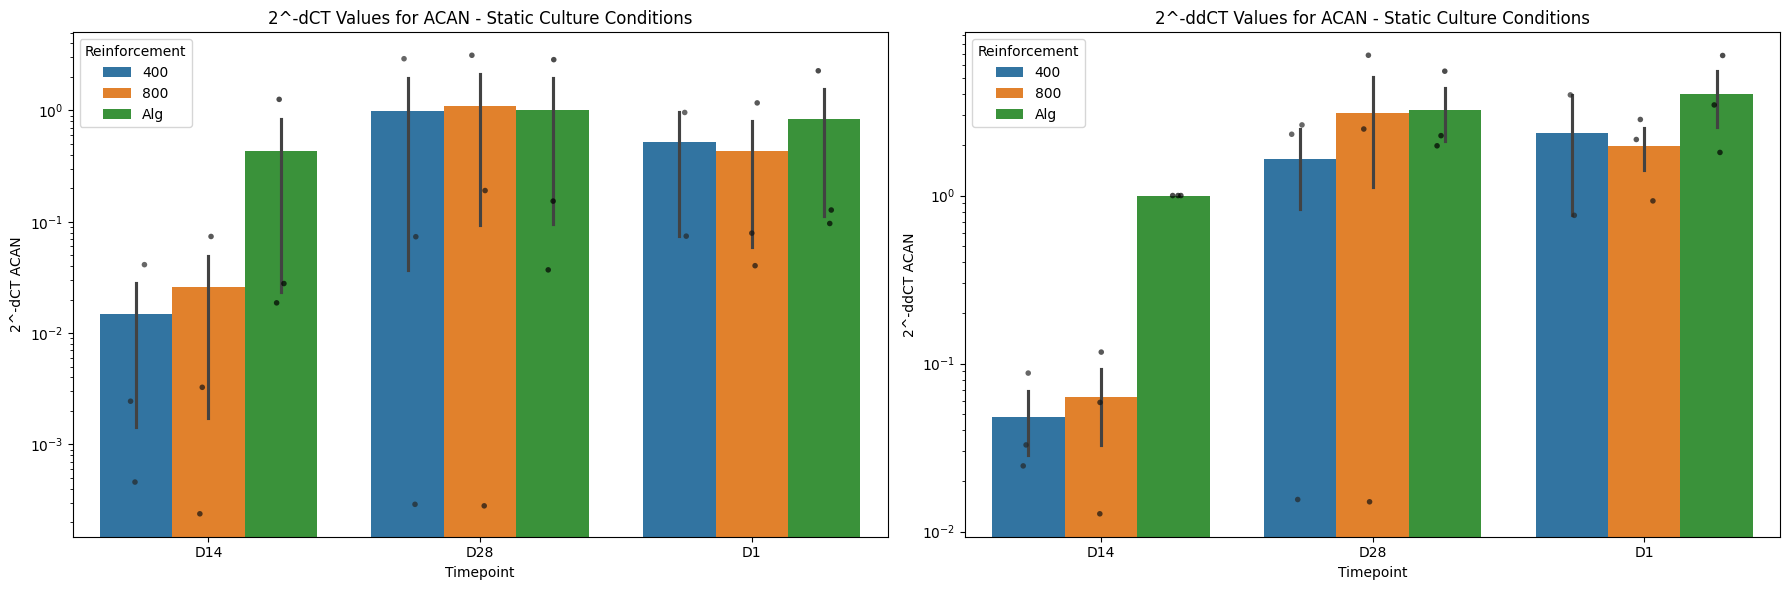

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:18: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=dct_col, hue='Reinforcement',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:29: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=ddct_col, hue='Reinforcement',


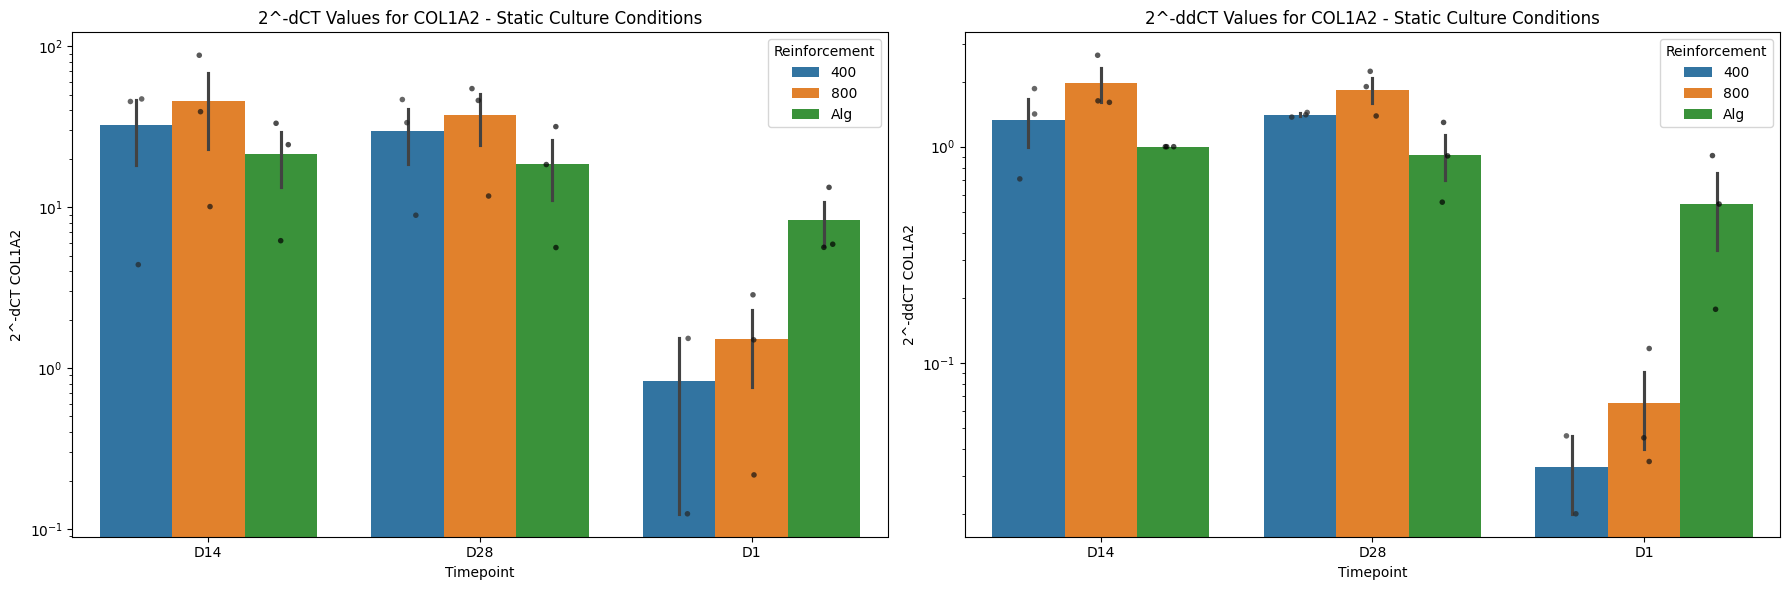

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:18: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=dct_col, hue='Reinforcement',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:29: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=ddct_col, hue='Reinforcement',


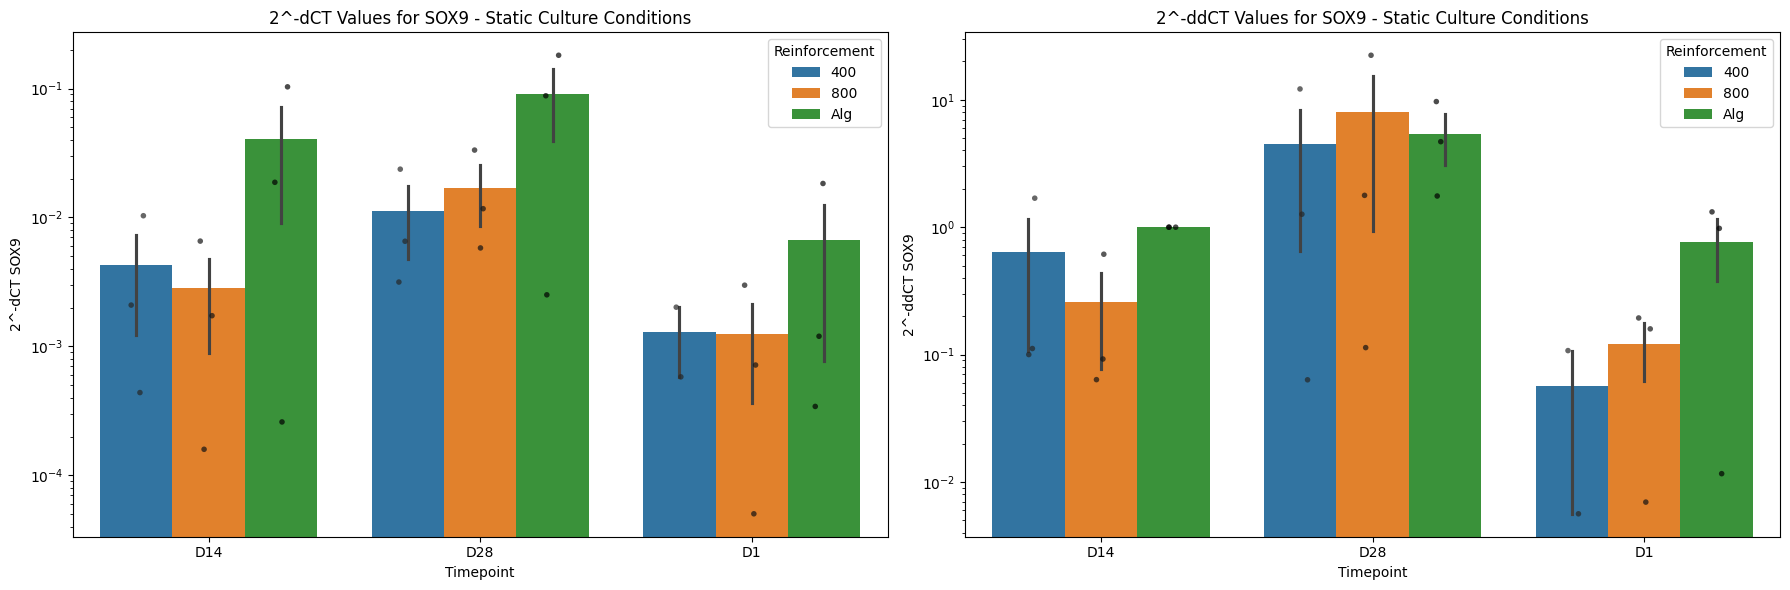

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:18: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=dct_col, hue='Reinforcement',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:29: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=ddct_col, hue='Reinforcement',


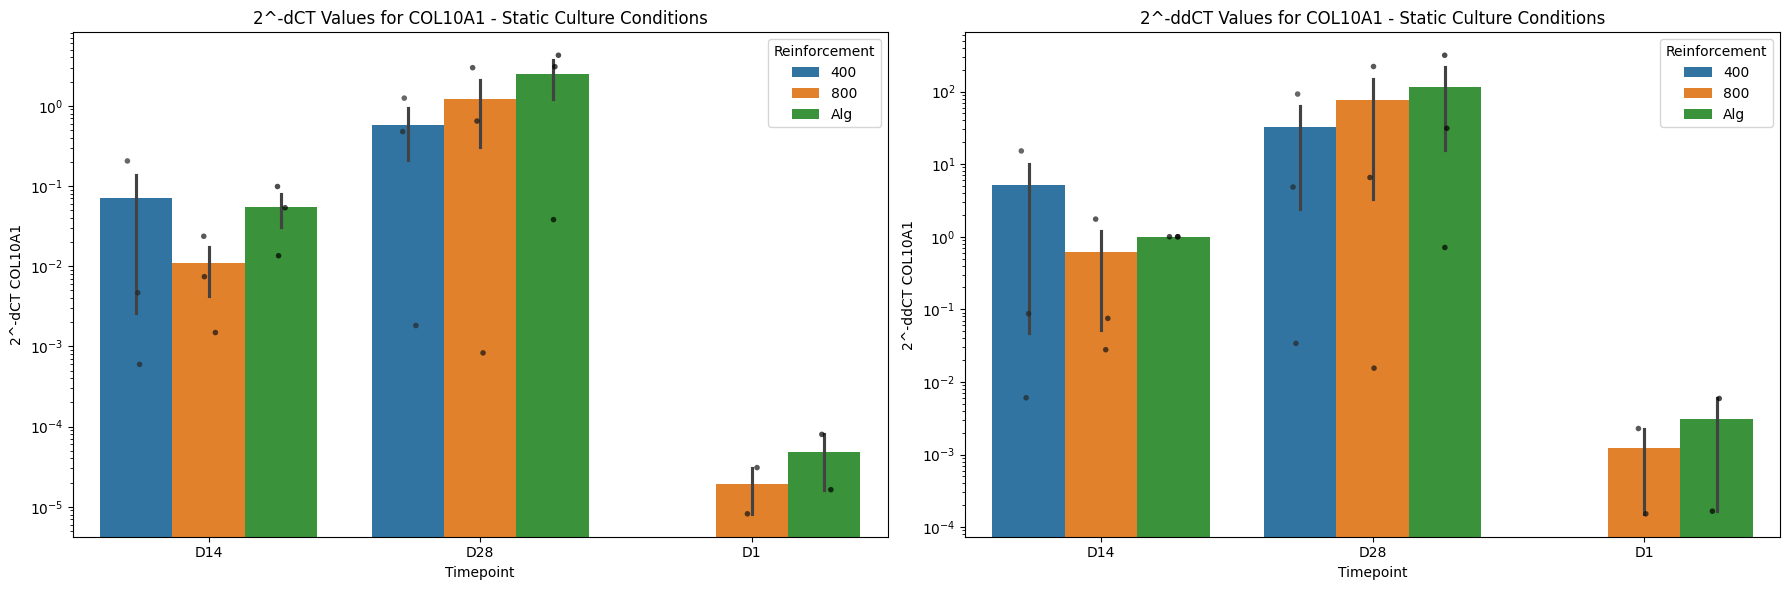

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:18: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=dct_col, hue='Reinforcement',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\1837296913.py:29: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_static, x='Timepoint', y=ddct_col, hue='Reinforcement',


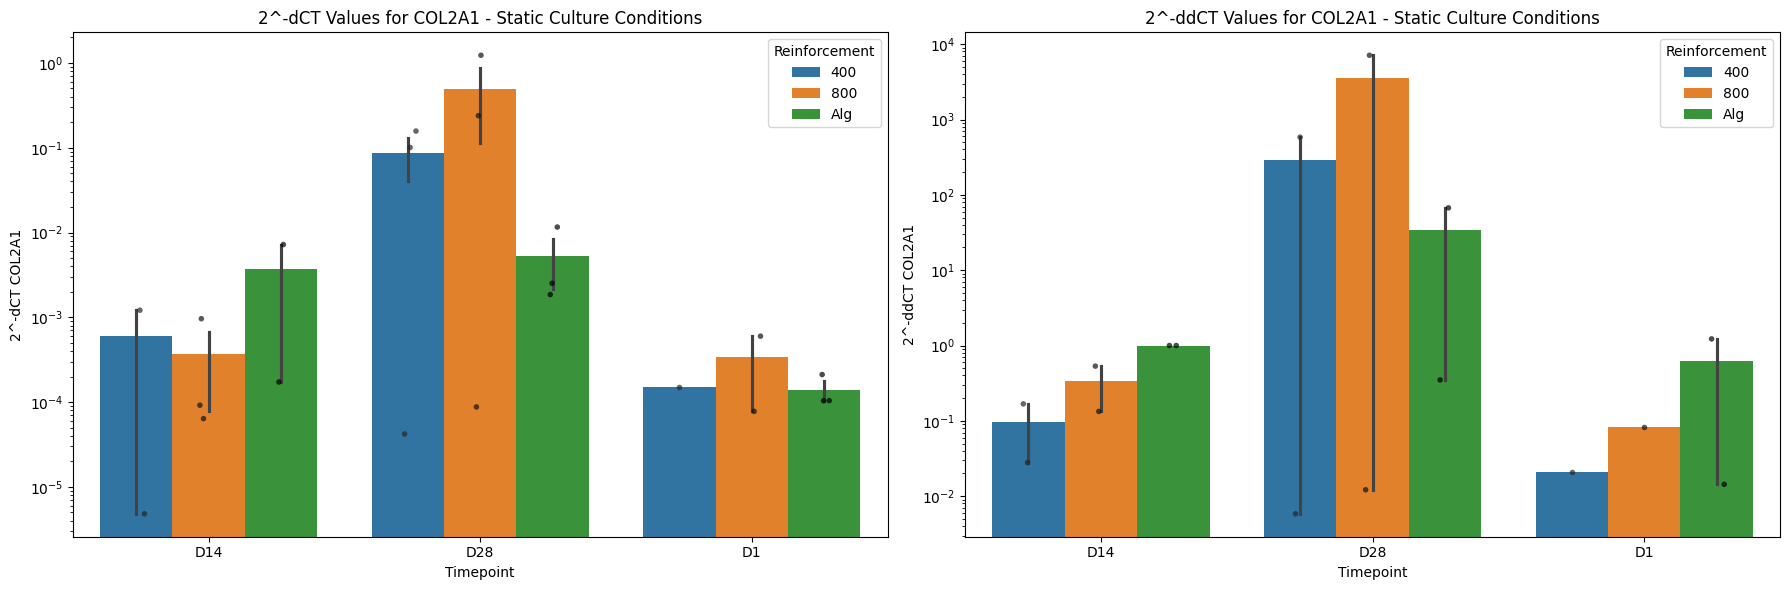

In [37]:
# Step 1: Filter the data for static culture conditions
df_static = results_df[results_df['Culture Conditions'] == 'S']

# Step 2: Extract target gene names (assuming column names include '2^-dCT' or '2^-ddCT' followed by the target gene)
target_genes = [col.split(' ')[-1] for col in df_static.columns if col.startswith('2^-dCT') or col.startswith('2^-ddCT')]
target_genes = list(set(target_genes))  # Unique target genes

for gene in target_genes:
    dct_col = f'2^-dCT {gene}'
    ddct_col = f'2^-ddCT {gene}'

    # Plot the bar charts for 2^-dCT values
    plt.figure(figsize=(18, 6))
    
    # Bar chart for 2^-dCT values
    plt.subplot(1, 2, 1)
    sns.barplot(data=df_static, x='Timepoint', y=dct_col, hue='Reinforcement', errorbar="se")
    sns.stripplot(data=df_static, x='Timepoint', y=dct_col, hue='Reinforcement', 
                  dodge=True, color='black', size=4, alpha=0.7, legend=False)
    plt.yscale('log')  # Set y-axis to log scale
    # plt.ylim(1e-1, 1e2)  # Set y-axis limits to a wider range
    plt.title(f'2^-dCT Values for {gene} - Static Culture Conditions')
    plt.ylabel(dct_col)
    plt.legend(title='Reinforcement')

    # Bar chart for 2^-ddCT values
    plt.subplot(1, 2, 2)
    sns.barplot(data=df_static, x='Timepoint', y=ddct_col, hue='Reinforcement', errorbar="se")
    sns.stripplot(data=df_static, x='Timepoint', y=ddct_col, hue='Reinforcement', 
                  dodge=True, color='black', size=4, alpha=0.7, legend=False)
    plt.yscale('log')  # Set y-axis to log scale 
    # plt.ylim(1e-2, 1e2)  # Set y-axis limits to a wider range
    plt.title(f'2^-ddCT Values for {gene} - Static Culture Conditions')
    plt.ylabel(ddct_col)
    plt.legend(title='Reinforcement')

    plt.tight_layout()
    plt.show()

    # # Perform two-way ANOVA analysis 
    # model_static = ols(f'{ddct_col} ~ C(Reinforcement) * C(Timepoint)', 
    #                    data={'values': df_static[ddct_col], 
    #                          'Reinforcement': df_static['Reinforcement'], 
    #                          'Timepoint': df_static['Timepoint']}).fit()
    # anova_static = sm.stats.anova_lm(model_static, typ=2)

    # print(f"ANOVA for {gene} - Static Culture Conditions:")
    # print(anova_static)

    # mc_static = pairwise_tukeyhsd(endog=df_static[ddct_col], 
    #                               groups=df_static['Reinforcement'] + ' at ' + df_static['Timepoint'],
    #                               alpha=0.05)
    # print("\nTukey's HSD Test for Static Culture Conditions:")
    # print(mc_static.summary())


C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:28: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=dct_col, hue='Culture Conditions',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:39: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=ddct_col, hue='Culture Conditions',


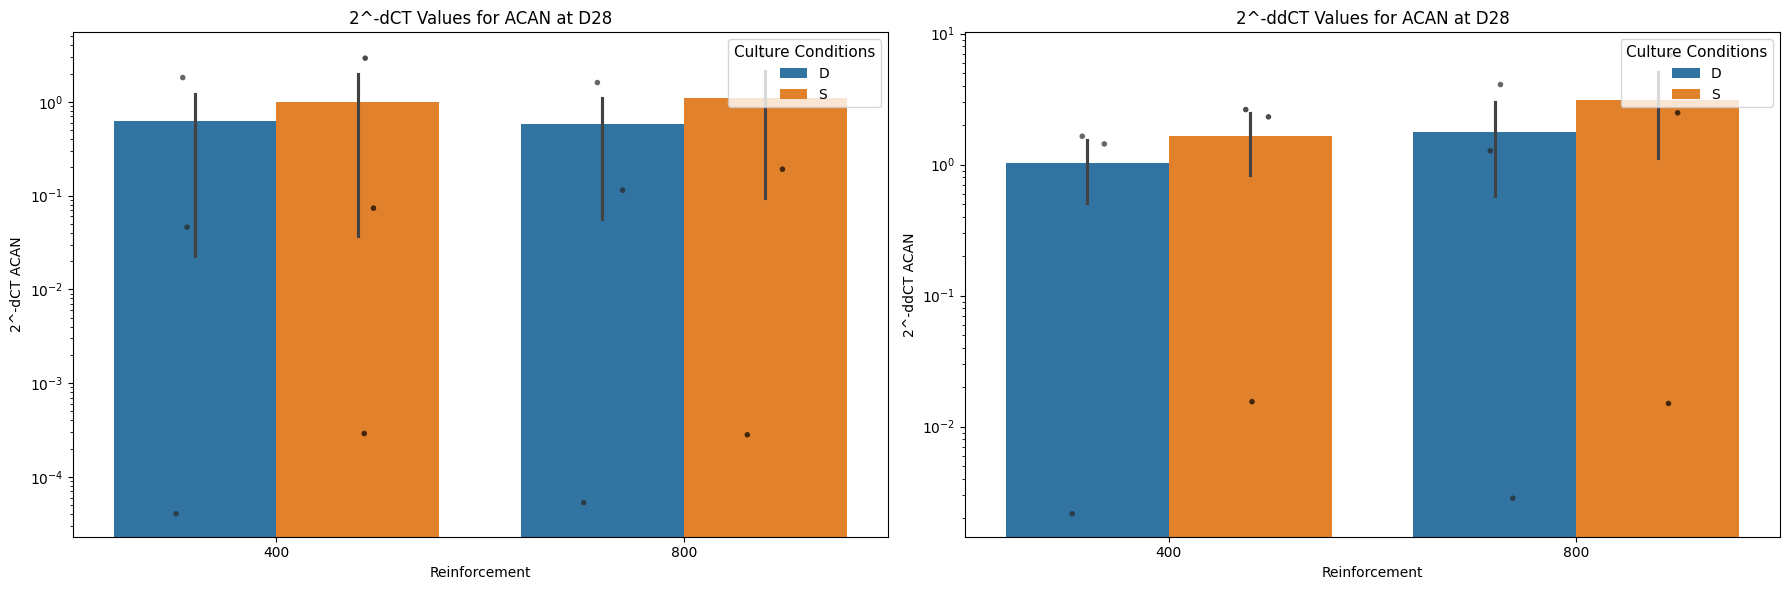

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:28: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=dct_col, hue='Culture Conditions',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:39: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=ddct_col, hue='Culture Conditions',


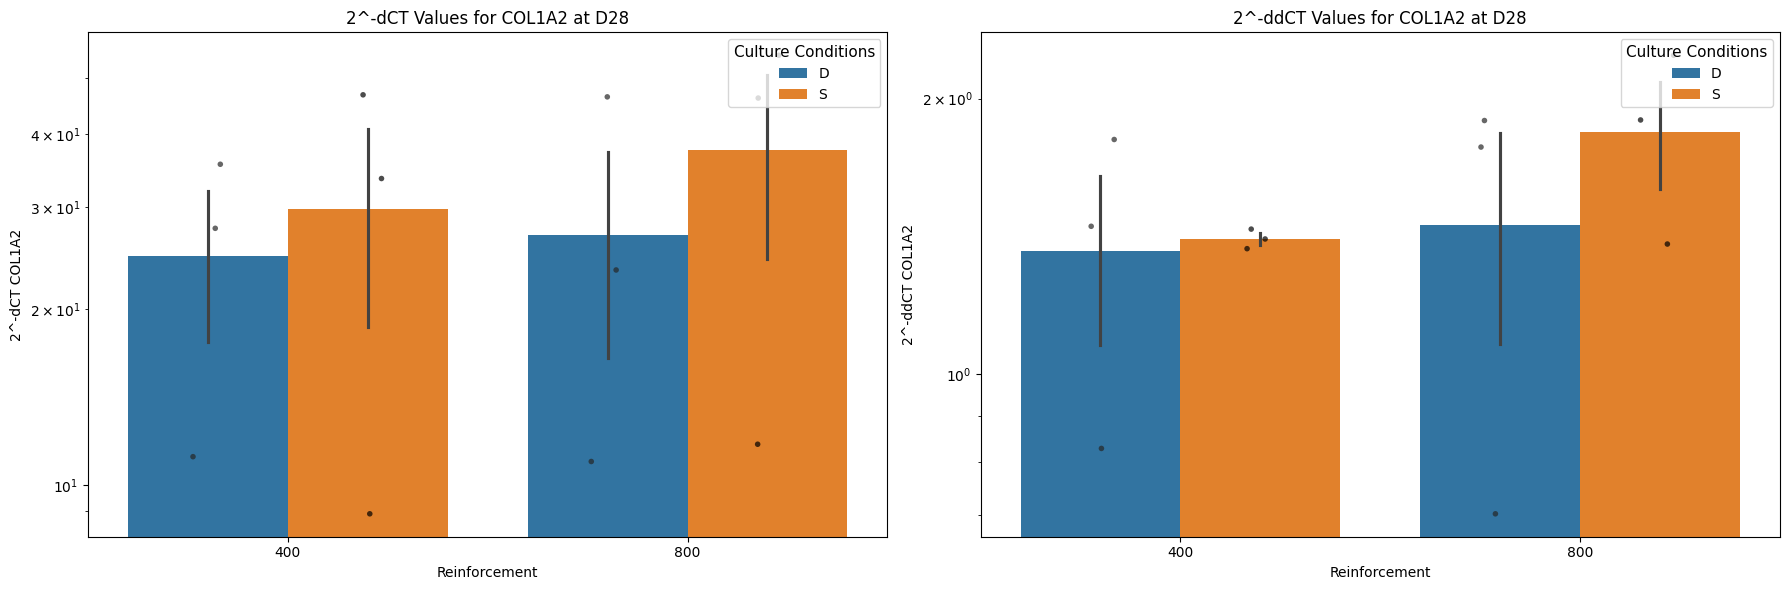

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:28: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=dct_col, hue='Culture Conditions',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:39: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=ddct_col, hue='Culture Conditions',


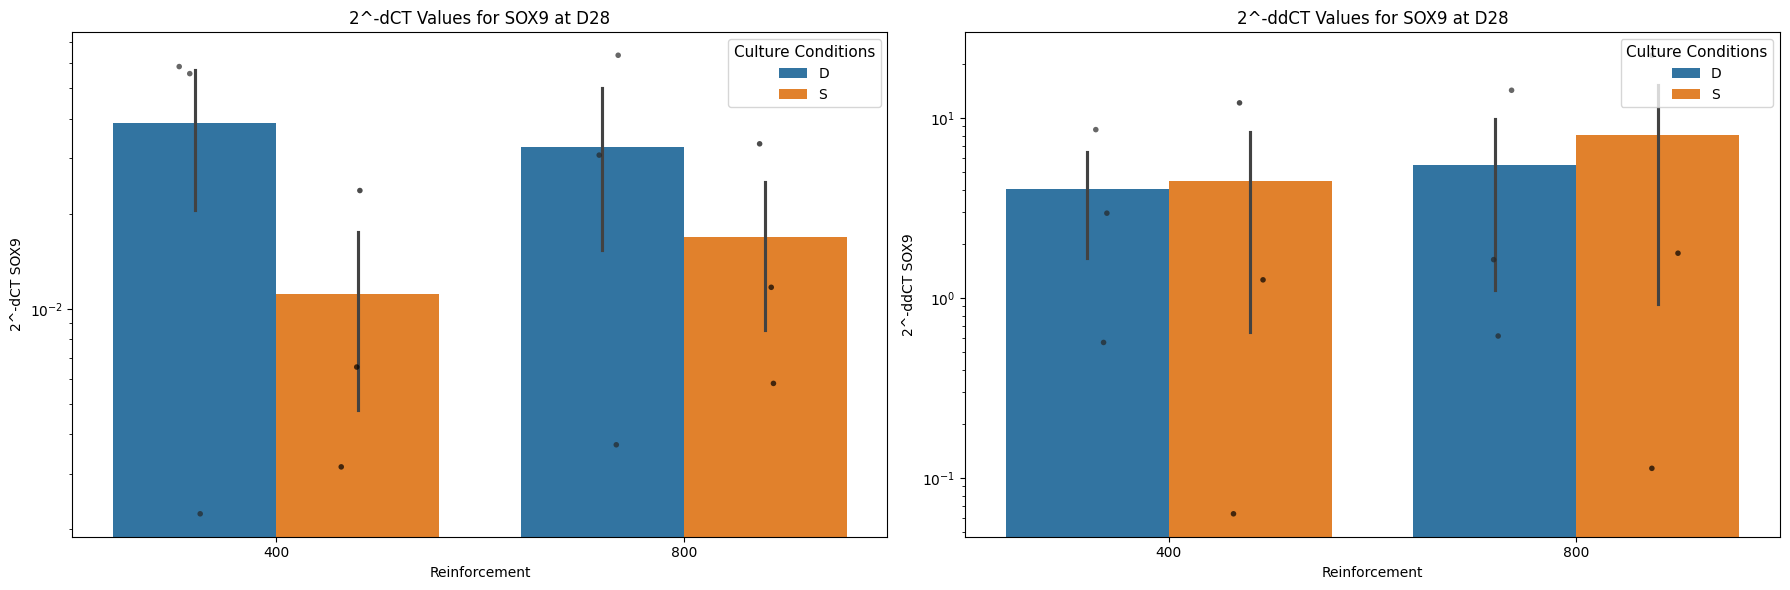

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:28: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=dct_col, hue='Culture Conditions',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:39: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=ddct_col, hue='Culture Conditions',


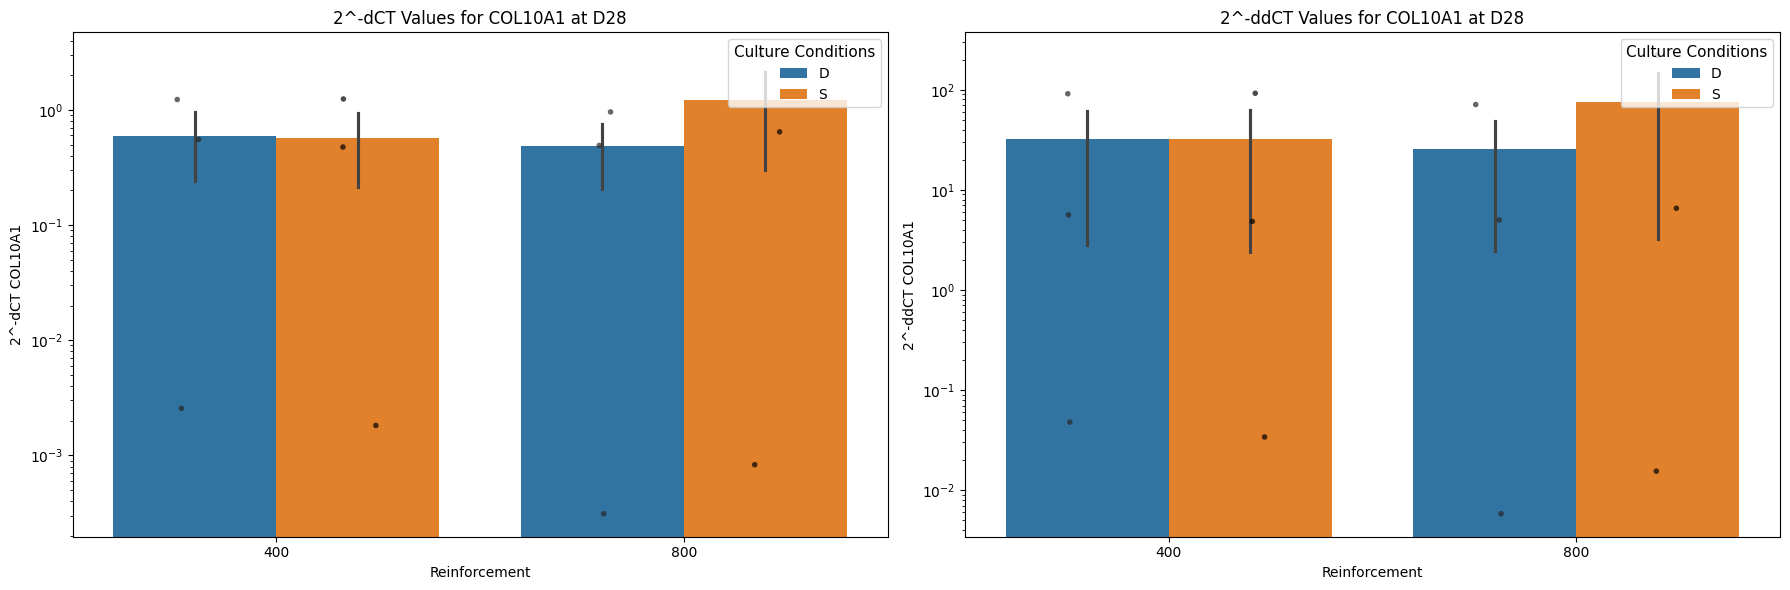

C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:28: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=dct_col, hue='Culture Conditions',
C:\Users\mbgm4fs3\AppData\Local\Temp\ipykernel_9512\2533800313.py:39: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=ddct_col, hue='Culture Conditions',


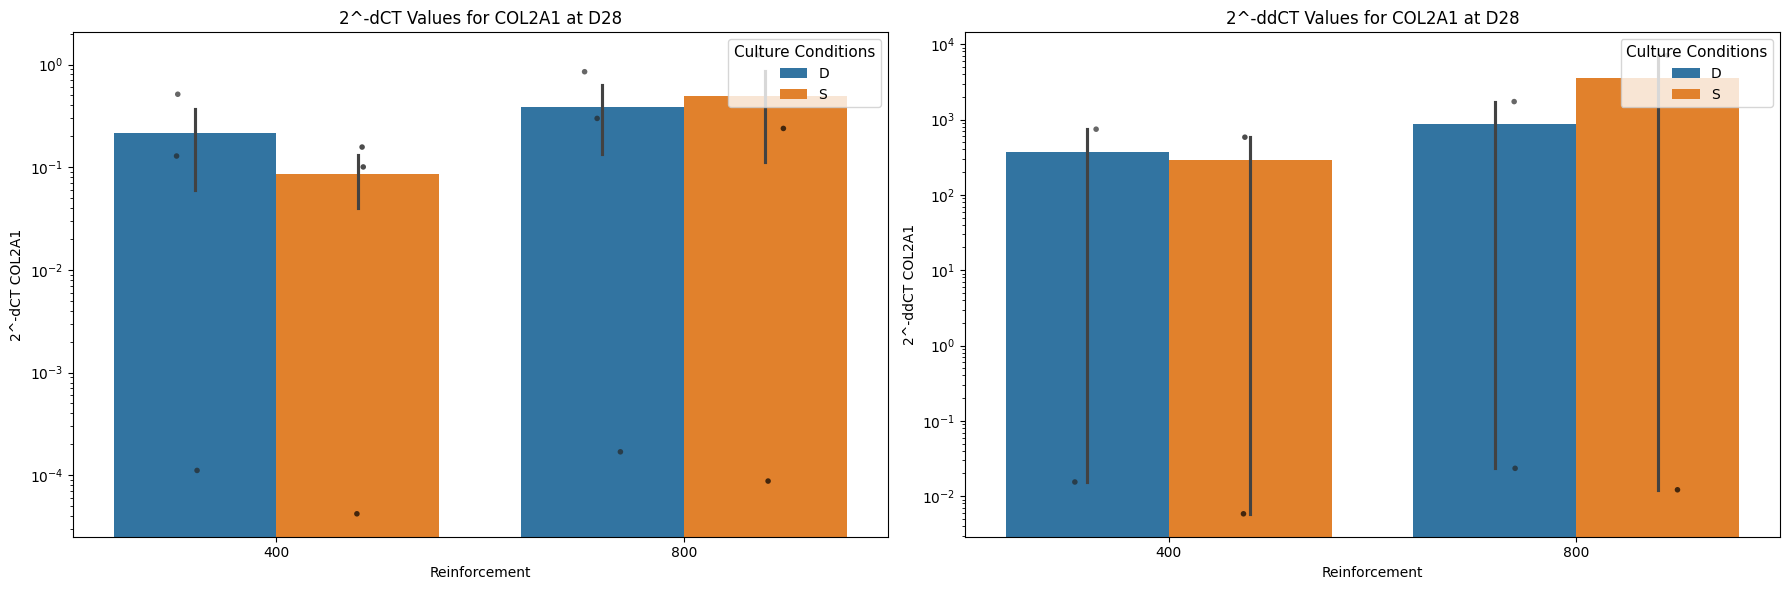

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example DataFrame for demonstration
# results_df = pd.read_csv('your_data.csv')

# Step 1: Filter the data for the last timepoint and selected reinforcements
df_end_timepoint = results_df[(results_df['Timepoint'] == 'D28') & (results_df['Reinforcement'].isin(['400', '800']))]

# Step 2: Extract target gene names (assuming column names include '2^-dCT' or '2^-ddCT' followed by the target gene)
target_genes = [col.split(' ')[-1] for col in df_end_timepoint.columns if col.startswith('2^-dCT') or col.startswith('2^-ddCT')]
target_genes = list(set(target_genes))  # Unique target genes

for gene in target_genes:
    dct_col = f'2^-dCT {gene}'
    ddct_col = f'2^-ddCT {gene}'

    # Plot the bar charts for 2^-dCT values
    plt.figure(figsize=(18, 6))

    # Bar chart for 2^-dCT values
    plt.subplot(1, 2, 1)
    sns.barplot(data=df_end_timepoint, x='Reinforcement', y=dct_col, hue='Culture Conditions', errorbar="se")
    sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=dct_col, hue='Culture Conditions', 
                  dodge=True, color='black', size=4, alpha=0.7, legend=False)
    plt.yscale('log')  # Set y-axis to log scale
    # plt.ylim(1, 1e3)  # Set y-axis limits to a wider range
    plt.title(f'2^-dCT Values for {gene} at D28')
    plt.ylabel(dct_col)
    plt.legend(title='Culture Conditions', loc='upper right', fontsize=10, title_fontsize=11)

    # Bar chart for 2^-ddCT values
    plt.subplot(1, 2, 2)
    sns.barplot(data=df_end_timepoint, x='Reinforcement', y=ddct_col, hue='Culture Conditions', errorbar="se")
    sns.stripplot(data=df_end_timepoint, x='Reinforcement', y=ddct_col, hue='Culture Conditions', 
                  dodge=True, color='black', size=4, alpha=0.7, legend=False)
    plt.yscale('log')  # Set y-axis to log scale
    # plt.ylim(1, 1e2)  # Set y-axis limits to a wider range
    plt.title(f'2^-ddCT Values for {gene} at D28')
    plt.ylabel(ddct_col)
    plt.legend(title='Culture Conditions', loc='upper right', fontsize=10, title_fontsize=11)

    plt.tight_layout()
    plt.show()

    # # Perform Two-Way ANOVA for the last timepoint
    # df_end_timepoint = df_end_timepoint.rename(columns={'Culture Conditions': 'Culture_Conditions'})

    # model_last_timepoint = ols(f'{ddct_col} ~ C(Reinforcement) * C(Culture_Conditions)', 
    #                            data={'values': df_end_timepoint[ddct_col], 
    #                                  'Reinforcement': df_end_timepoint['Reinforcement'], 
    #                                  'Culture_Conditions': df_end_timepoint['Culture_Conditions']}).fit()
    # anova_last_timepoint = sm.stats.anova_lm(model_last_timepoint, typ=2)

    # print(f"ANOVA for {gene} at D28:")
    # print(anova_last_timepoint)

    # # Perform Tukey's HSD test for multiple comparisons
    # mc_last_timepoint = pairwise_tukeyhsd(endog=df_end_timepoint[ddct_col], 
    #                                       groups=df_end_timepoint['Reinforcement'] + ' in ' + df_end_timepoint['Culture_Conditions'],
    #                                       alpha=0.05)

    # print("\nTukey's HSD Test for {gene} at D28:")
    # print(mc_last_timepoint.summary())
